# Datalaoder-Based Relation Augmentation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
from os import environ

environ['DATA_DIR_VG_RCNN'] = '/home/zhanwen/datasets'

In [4]:
from maskrcnn_benchmark.modeling.detector import build_detection_model

In [5]:
from torch import manual_seed as torch_manual_seed
import random
import numpy as np

from torch.cuda import max_memory_allocated, set_device, manual_seed_all
from torch.backends import cudnn

def setup_seed(seed):
    torch_manual_seed(seed)
    manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    cudnn.deterministic = True
    
setup_seed(1234)

In [6]:
# Set args
# PRETRAINED
from maskrcnn_benchmark.config import cfg

MODEL_NAME = '44663493_vctree_baseline_predcls_4GPU_riv_1_copied'
CONFIG_FILE = '/home/zhanwen/gsc/checkpoints/44663493_vctree_baseline_predcls_4GPU_riv_1_copied/config.yml'
PROJECT_DIR = '/home/zhanwen/gsc'
SEED=1234
BATCH_SIZE=1

cfg.merge_from_file(CONFIG_FILE)
cfg.SOLVER.IMS_PER_BATCH = BATCH_SIZE
cfg.DATALOADER.NUM_WORKERS = 8
cfg.GLOVE_DIR = f'{PROJECT_DIR}/datasets/vg/'
cfg.MODEL.PRETRAINED_DETECTOR_CKPT = f'{PROJECT_DIR}/checkpoints/pretrained_faster_rcnn/model_final.pth'
cfg.OUTPUT_DIR = f'{PROJECT_DIR}/checkpoints/{MODEL_NAME}'
cfg.PATHS_DATA = f'{PROJECT_DIR}/maskrcnn_benchmark/data/datasets'
cfg.OUTPUT_DIR = '/home/zhanwen/gsc/checkpoints/44663493_vctree_baseline_predcls_4GPU_riv_1_copied'
cfg.MODEL.WEIGHT = f'{PROJECT_DIR}/checkpoints/{MODEL_NAME}/model_0014000.pth'
cfg.PATHS_CATALOG = '/home/zhanwen/gsc/maskrcnn_benchmark/config/paths_catalog.py'

cfg.freeze()

In [7]:
cfg.MODEL.ROI_RELATION_HEAD.PREDICTOR 

'VCTreePredictor'

In [8]:
from os.path import basename as os_path_basename
from maskrcnn_benchmark.utils.checkpoint import DetectronCheckpointer

from os.path import exists as os_path_exists
from torch import save as torch_save, load as torch_load

# MODEL_NAME = 'model.pt'
# if os_path_exists(MODEL_NAME):
#     model = torch_load(MODEL_NAME, map_location='cpu')
# else:
#     model = build_detection_model(cfg)
#     model_checkpoint_name = os_path_basename(cfg.MODEL.WEIGHT)
#     checkpointer = DetectronCheckpointer(cfg, model, save_dir=cfg.OUTPUT_DIR)
#     _ = checkpointer.load(cfg.MODEL.WEIGHT)
#     torch_save(model, MODEL_NAME)


In [9]:
from os.path import exists as os_path_exists
from torch import save as torch_save, load as torch_load

# MODEL_NAME = 'model.pt'
# if os_path_exists(MODEL_NAME):
#     model = torch_load(MODEL_NAME, map_location='cpu')
# else:
#     model = build_detection_model(cfg)
#     torch_save(model, MODEL_NAME)
        

# Deliverable: Walk through it once and compute the statistics

In [10]:
# Where is the dataset statistics computed?

In [11]:
from maskrcnn_benchmark.data import make_data_loader

train_data_loader = make_data_loader(
        cfg,
        mode='train',
        is_distributed=False,
        start_iter=0,
    )

Images Per GPU: 1


split:  train
root_classes_count:  {}
mean root class number:  0.0
sum root class number:  0
leaf_classes_count:  {}
mean leaf class number:  0.0
sum leaf class number:  0
all_classes_count:  {}
mean all class number:  0.0
sum all class number:  0
number images:  57723


In [12]:
from numpy import log as np_log

from maskrcnn_benchmark.data import get_dataset_statistics # calls VisualGenome.get_statistics which calls get_VG_statistics

statistics = get_dataset_statistics(cfg)

fg_matrix = statistics['fg_matrix']
eps = 1e-3

pred_dist = np_log(fg_matrix / fg_matrix.sum(2)[:, :, None] + eps)


# Let's Manually Calculate the correlations from the foreground matrix which is 

```python
fg_matrix = np_zeros((num_obj_classes, num_obj_classes, num_rel_classes), dtype=np_int64)
```

In [13]:
fg_matrix.size()

torch.Size([151, 151, 51])

# Let's define relation-relation correlation

1. Relation Word Embedding Similarity
2. Relation Co-occurrence
3. Relation covariance

## 1. Relation Word Embedding Similarity

```python
for i in idx2label_177:
    for j in idx2label_177:
        if i == j:
            continue
        a = wn.synset(label2synset_combined[idx2label_177[i]])
        b = wn.synset(label2synset_combined[idx2label_177[j]])
        s1 = a.path_similarity(b)
        s2 = a.lch_similarity(b) / 3.6375861597263857
        s3 = a.wup_similarity(b)
        word_sim[:, int(i), int(j)] = [s1, s2, s3]
```

# 2. Relation Co-occurrence

In [14]:
lol = fg_matrix.sum((0,1))

In [15]:
lol2 = lol[:, None] / lol[None, :]

In [16]:
lol2.size()

torch.Size([51, 51])

# Naive Relation Augmentation Strategies

1. Relation augmentation given pred (like the bar plots)
2. Relation augmentation given subj, pred
3. Relation augmentation given obj, pred
4. Relation augmentation given subj, obj, pred
5. Relation augmentation given pred2pred knowledge (word embedding) with an alpha control
6. Relation augmentation given pred2pred knowledge (commonsense knowledge - just ConceptNet) with a beta control


# 1. Relation augmentation given pred (like the bar plots)


In [17]:
pred_counts = fg_matrix.sum((0,1))

In [18]:
pred_counts

tensor([3024465,    6712,     171,     208,     379,     504,    1829,    1413,
          10011,     644,     394,    1603,     397,     460,     565,       4,
            809,     163,     157,     663,   67144,   10764,   21748,    3167,
            752,     676,     364,     114,     234,   15300,   31347,  109355,
            333,     793,     151,     601,     429,      71,    4260,      44,
           5086,    2273,     299,    3757,     551,     270,    1225,     352,
          47326,    4810,   11059])

In [19]:
pred_freq_pairwise = pred_counts[:, None] / pred_counts[None, :]

In [20]:
# from torch import empty_like as torch_empty_like
# pred2pred = torch_zeros(51, 51)

# for i in range(51):
#     for j in range(51):
#         preds_ij = fg_matrix[i, j].float()
        
#         print('before, preds_ij =', preds_ij)
# #         print(preds_ij)
        
#         preds_ij = cov[i, j, :] = preds_ij/preds_ij.sum()
#         # PyTorch impl
# #         m = preds_ij.mean()
# #         s = preds_ij.std(un|biased=False)
# #         preds_ij -= m
# #         preds_ij /= s
#         print('after, preds_ij =', preds_ij)
#         print('after, preds_ij.sum() =', preds_ij.sum())
#         pred2pred[]
        

In [21]:
# fg_matrix.float().cov((0,1)).size()

In [22]:
# torch_cov(fg_matrix)

# 3. Relation Covariance

# 4. Knowledge-Based

# Question: How did others (like KERN and GB-Net) get their correlations?

In [23]:
len(train_data_loader)

50000

In [24]:
train_dataset = train_data_loader.dataset

In [25]:
img, target, index = train_dataset[0]

In [26]:
labels = target.extra_fields['labels']
labels

tensor([  3,  20,  49,  49,  57,  58,  59,  97,  99, 105, 111, 115,  77,  78])

In [27]:
relations = target.extra_fields['relation']
relations

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0, 50,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 31,  0,  0,  0],
        [ 0,  0,  0,  0,  0, 20,  0, 21,  0,  0,  0,  0,  0,  0]])

In [28]:
relations[relations.nonzero(as_tuple=True)]

tensor([20, 50, 31, 20, 21])

In [29]:
subj_id, obj_id = relations_idx = relations.nonzero(as_tuple=True)
print(subj_id)
print(obj_id)
print(relations_idx)

tensor([ 1, 11, 12, 13, 13])
tensor([ 0,  8, 10,  5,  7])
(tensor([ 1, 11, 12, 13, 13]), tensor([ 0,  8, 10,  5,  7]))


In [30]:
import json
from os.path import join as os_path_join
from os import environ as os_environ

DATA_DIR = os_environ['DATA_DIR_VG_RCNN']

with open(os_path_join(DATA_DIR, 'visual_genome', 'VG-SGG-dicts-with-attri.json'), 'r') as fin:
    scene_graph_meta = json.load(fin)
labels = list(scene_graph_meta['label_to_idx'].keys())
preds = list(scene_graph_meta['predicate_to_idx'].keys())

# TODO: limit to tail classes for freq. Because if I just do a freq based, I'm gonna 
# make it worse because we are gonna get the higher freq ones for aug triplets.
# or just invert it.

In [31]:
idx2preds = ['_'] + list(scene_graph_meta['idx_to_predicate'].values())

In [32]:
idx2preds_np = np.array(idx2preds)

In [33]:
# idx2preds_np[triplets_new[1]]

In [34]:
from typing import Tuple
from torch import Tensor
from maskrcnn_benchmark.structures.image_list import ImageList
from maskrcnn_benchmark.structures.bounding_box import BoxList



def rel_aug(images: ImageList, targets: Tuple[BoxList], num_to_aug: int, strategy: str) -> Tuple[ImageList, Tuple[BoxList]]:
    p_rel_all = pred_counts/pred_counts.sum()
    if strategy == 'all':
        return rel_aug_all(images, targets, p_rel_all, num_to_aug)
    else:
        raise NotImplementedError(f'rel_aug: strategy={strategy} is not implemented yet')


from torch import as_tensor as torch_as_tensor
# def rel_aug_all_triplets(triplet: Tuple[Tensor, Tensor, Tensor], num2aug: int, replace: bool) -> Tuple[Tensor, Tensor, Tensor]:
def rel_aug_all_triplets(idx_rel: int, num2aug: int, replace: bool) -> Tuple[Tensor, Tensor, Tensor]:
    '''
    Given a single triplet in the form of (subj, rel, obj) and outputs a list of triplets with
    the , not including the original. You should append the original.
    
    Note that the input indices much be singular (one element) but the outputs will have multiple
    (specificall num2aug elements).
    '''
    
    # Construct the inverse relation frequency distribution
    
    n=len(pred_counts)
    P_REL_ALL = 1- (pred_counts/pred_counts.sum()).repeat(n, 1)
    DIST_RELS_ALL_EXCLUDED_BY = P_REL_ALL.flatten()[1:].view(n-1, n+1)[:,:-1].reshape(n, n-1) # remove diagonal values

#     idxs_subj = []
#     idxs_obj = []
#     idxs_rel = []
    
#     idx_subj, idx_rel, idx_obj = triplet
    
    idx_chosen = DIST_RELS_ALL_EXCLUDED_BY[idx_rel].multinomial(num2aug, replacement=replace)
    return idx_chosen
#     idxs_subj.append([idx_subj for _ in range(num2aug)])
#     idxs_obj.append([idx_obj for _ in range(num2aug)])
#     idxs_rel.extend(idx_chosen)
#     return torch_as_tensor(idxs_subj), torch_as_tensor(idxs_rel), torch_as_tensor(idxs_obj)

def rel_aug_each_instance(triplet: Tuple[Tensor, Tensor, Tensor], num2aug: int, replace: bool) -> Tuple[Tensor, Tensor, Tensor]:
    '''
    Given a single triplet in the form of (subj, rel, obj) and outputs a list of triplets with
    the , not including the original. You should append the original.
    
    Note that the input indices much be singular (one element) but the outputs will have multiple
    (specificall num2aug elements).
    '''
    
    # Construct the inverse relation frequency distribution
    
    n=len(pred_counts)
    P_REL_ALL = 1- (pred_counts/pred_counts.sum()).repeat(n, 1)
    DIST_RELS_ALL_EXCLUDED_BY = P_REL_ALL.flatten()[1:].view(n-1, n+1)[:,:-1].reshape(n, n-1) # remove diagonal values

    idxs_subj = []
    idxs_obj = []
    idxs_rel = []
    
    idx_subj, idx_rel, idx_obj = triplet
    
    idx_chosen = DIST_RELS_ALL_EXCLUDED_BY[idx_rel].multinomial(num2aug, replacement=replace)
    return idx_chosen
#     idxs_subj.append([idx_subj for _ in range(num2aug)])
#     idxs_obj.append([idx_obj for _ in range(num2aug)])
#     idxs_rel.extend(idx_chosen)
#     return torch_as_tensor(idxs_subj), torch_as_tensor(idxs_rel), torch_as_tensor(idxs_obj)

def rel_aug_all(images: ImageList, targets: Tuple[BoxList], dist_rels_all:Tensor, num2aug: int, replace: bool) -> Tuple[ImageList, Tuple[BoxList]]:
    '''
    dist_preds_all:Tensor: the frequency distribution of all relations
    num2aug:int: 
    
    '''
    batch_size = image.size()[0]
    # pick up the num_examples draw given distribution of similar 
    
    # 1. Exclude iteratively or better, build cached matrix of excluded distributions by index.
    
#     for 
    n = preds_count.size(0)
    dist_rels_all_excluded_by = dist_rels_all.flatten()[1:].view(n-1, n+1)[:,:-1].reshape(n, n-1) # remove diagonal values

    # Exclude head relation classes or include tail relation classes.
    triplets_augmented = []
    for t in triplets:
        idx_subj, idx_obj, idx_rel = t
        idx_chosen = dist_rels_all_excluded_by[idx_rel].multinomial(num2aug, replacement=replace)
        # Actually idx_chosen is the new array of augmentation triplets
        # Augment here
#         triplets_chosen = 
        # same objects.
        triplets_augmented.extend(triplets_chosen)
    
    return images, targets



# def mixgen_batch(image, text, num, lam=0.5):
#     batch_size = image.size()[0]
#     index = np.random.permutation(batch_size)
#     for i in range(batch_size):
#         # image mixup
#         image[i,:] = lam * image[i,:] + (1 - lam) * image[index[i],:]
#         # text concat
#         text[i] = text[i] + " " + text[index[i]]
#     return image, text

In [35]:
from tqdm import tqdm
from copy import deepcopy
from torch import no_grad as torch_no_grad, cat as torch_cat, as_tensor as torch_as_tensor
from maskrcnn_benchmark.structures.image_list import to_image_list


# for iteration, (images, targets, _) in tqdm(enumerate(train_data_loader)):
#     if iteration > 100: break


def augment_targets(images, targets):
    # TODO: vectorize
#     relations = [target.extra_fields['relation'] for target in targets]
#     labels = [target.extra_fields['labels'] for target in targets]
    images_augmented = []
    targets_augmented = []
    for image, target in zip(images.tensors, targets):
        relation_old = target.extra_fields['relation']
    
        idx_subj, idx_obj = idx_rel = relation_old.nonzero(as_tuple=True) # tuple
        rels = relation_old[idx_rel]
        # Future idea: relation localization. Why are objects locally & globally indexed 
        # but relations only globally indexed? Because of bbox?

        # triplets are represented as the relation map.

        # rels is essentially triplets

#         idxs_subj = []
#         idxs_rel = []
#         idxs_obj = []
        
#         images_from_image = []
#         targets_from_target = []
        images_augmented.append(image)
        targets_augmented.append(target)


        for idx_subj_og, rel_og, idx_obj_og in zip(idx_subj, rels, idx_obj):
#             idx_subj, idx_rel, idx_obj = rel_aug_all_triplets(triplets_old, 10, True)

            # First add old
#             images_from_image.append(image)
            # TODO: how to append to an ImageList? Use to_image_list to convert torch tensors
#             targets_from_target.append(target)
            # TODO: how to append to targets? It's a list of boxlists. So might be easier.

#             triplets_new = rel_aug_all_triplets(triplet_old, 10, True)
#             triplets_new = rel_aug_all_triplets(rel_og, 10, True)
            rels_new = rel_aug_all_triplets(rel_og, 10, True)
            print(len(rels_new))
            for rel_new in rels_new:
#                 images_from_image.append(image)
                images_augmented.append(image)
                
                # NOTE on meditation and working and reducing anxiety and zen: remember
                # doing math proofs in the downstairs apartment? How calm and focused I was?
                # like Xin Ru Zhi Shui.
                
                # Only idx_rel is new here.
#                 idx_obj, idx_rel, idx_subj = triplet_new
                
                # Triplet to Map
                relation_new = relation_old.detach().clone()
#                 target_new = target.detach().clone()
                target_new = deepcopy(target)
                relation_new[idx_subj_og, idx_subj_og] = rel_new
                target_new.extra_fields['relation'] = relation_new
#                 targets_from_target.append(target_new)
#                 targets_from_target.append(target_new)
                targets_augmented.append(target_new)
#     import pdb; pdb.set_trace()
    return to_image_list(images_augmented), targets_augmented
                
                # Do we really need to recreate relation_old from zeros? I don't think so. 
                
#                 (x == 0).nonzero()
#                 x = torch.empty(5, 5).random_(3)
#                 idx = x.nonzero()
#                 y = torch.zeros(5, 5)
#                 y[idx[:,0], idx[:,1]] = x[idx[:, 0], idx[:, 1]]
#                 print((x==y).all())
                
#             idxs_subj.append(idx_subj)
#             idxs_rel.append(idx_rel)
#             idxs_obj.append(idx_obj)
            
            # For single-label augmentation, each iteration in this loop is an "extra" image and target
            

#         idxs_subj = torch_cat(idxs_subj)
#         idxs_rel = torch_cat(idxs_rel)
#         idxs_obj = torch_cat(idxs_obj)
        
#         import pdb; pdb.set_trace()
        
        # TODO: convert matrices back into map like relation_old [num_obj, num_obj]
        # currently, these maps are singular in terms of relations. We cannot have multiple.
        # perhaps we need multilabel anyway? One way to do this is to borrow from the MLSGG codebase.
        # Alternatively, output multiple maps with the same images and targets but with different gt map.
        
        # But doesn't single-label run into problem of bad gt answers? Can both be correct? I'm not so sure.
        
        
#         target.extra_fields['relation'] = 

#     return targets

    # where is the ground truth relation labels? There's definitely some in get_dataset_statistics
   

In [61]:
pred_count_dict = dict(zip(idx2preds[1:], pred_counts[1:].tolist()))

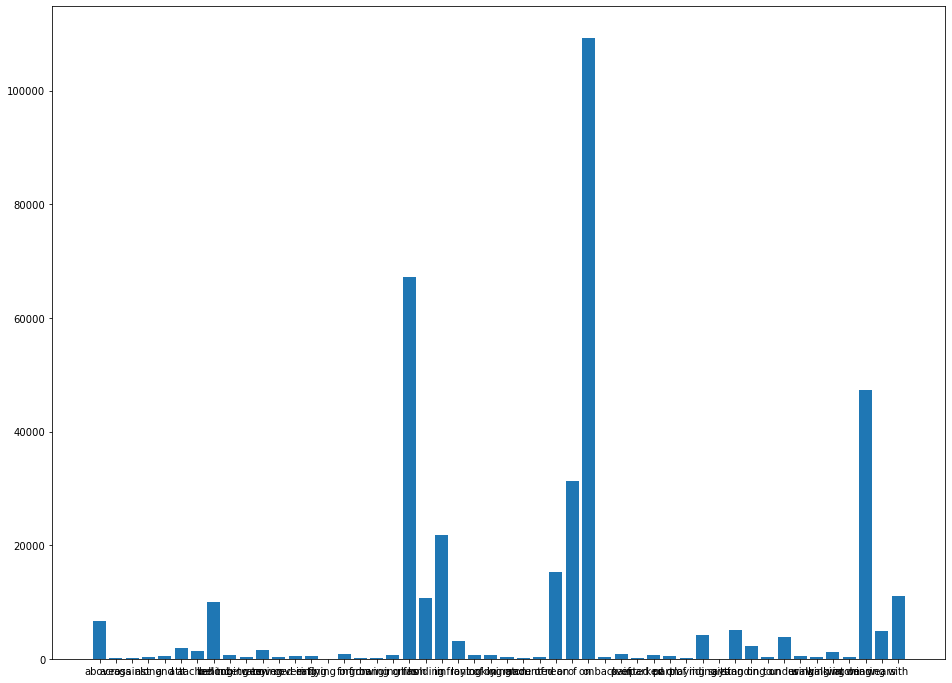

In [65]:
from matplotlib import pyplot as plt

# mylist = [key for key, val in pred_count_dict.items() for _ in range(val)]
plt.figure(figsize=(16, 12))
names, counts = zip(*pred_count_dict.items())
plt.bar(names, counts)
# plt.hist(mylist, bins=20)
# plt.hist(pred_counts)
# plt.hist(pred_counts.tolist())
# plt.tight_layout()
plt.savefig('preds.png')
plt.show()

In [66]:
p_rel_all = pred_counts/pred_counts.sum()


In [69]:
from torch import sort as torch_sort

In [85]:
pred_counts_sorted, pred_counts_sorted_indices = torch_sort(pred_counts[1:], descending=False)

In [91]:
pred_counts_sorted, pred_counts_sorted_indices = torch_sort(pred_counts, descending=False)

In [92]:
pred_counts_sorted

tensor([      4,      44,      71,     114,     151,     157,     163,     171,
            208,     234,     270,     299,     333,     352,     364,     379,
            394,     397,     429,     460,     504,     551,     565,     601,
            644,     663,     676,     752,     793,     809,    1225,    1413,
           1603,    1829,    2273,    3167,    3757,    4260,    4810,    5086,
           6712,   10011,   10764,   11059,   15300,   21748,   31347,   47326,
          67144,  109355, 3024465])

In [103]:
set(pred_counts_sorted_indices[:30].tolist())

{2,
 3,
 4,
 5,
 9,
 10,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 24,
 25,
 26,
 27,
 28,
 32,
 33,
 34,
 35,
 36,
 37,
 39,
 42,
 44,
 45,
 47}

In [95]:
pred_counts[pred_counts_sorted_indices[:30]]

tensor([  4,  44,  71, 114, 151, 157, 163, 171, 208, 234, 270, 299, 333, 352,
        364, 379, 394, 397, 429, 460, 504, 551, 565, 601, 644, 663, 676, 752,
        793, 809])

In [96]:
indices_bottom_k = pred_counts_sorted_indices[:30]

pred_counts[indices_bottom_k]

tensor([  4,  44,  71, 114, 151, 157, 163, 171, 208, 234, 270, 299, 333, 352,
        364, 379, 394, 397, 429, 460, 504, 551, 565, 601, 644, 663, 676, 752,
        793, 809])

In [100]:
pred_counts_sorted_indices[30:]

tensor([46,  7, 11,  6, 41, 23, 43, 38, 49, 40,  1,  8, 21, 50, 29, 22, 30, 48,
        20, 31,  0])

In [99]:
pred_counts[~indices_bottom_k]

tensor([   601,   1603,    460,   3167,    809,    333,    793,  47326,    352,
         21748,    504,  10011,    157,    208,    752,   1225,   5086,   4260,
           565,     71,    270,   1829,    429,      4,   2273, 109355,    676,
           364,    163,    151])

In [104]:
idx2preds_np[15]

'flying in'

In [86]:
pred_count_dict = dict(zip(idx2preds_np[1:][pred_counts_sorted_indices], pred_counts[1:][pred_counts_sorted_indices].tolist()))

In [87]:
pred_count_dict

{'flying in': 4,
 'says': 44,
 'playing': 71,
 'made of': 114,
 'painted on': 151,
 'growing on': 157,
 'from': 163,
 'across': 171,
 'against': 208,
 'mounted on': 234,
 'walking in': 270,
 'to': 299,
 'on back of': 333,
 'watching': 352,
 'lying on': 364,
 'along': 379,
 'between': 394,
 'covered in': 397,
 'part of': 429,
 'covering': 460,
 'and': 504,
 'using': 551,
 'eating': 565,
 'parked on': 601,
 'belonging to': 644,
 'hanging from': 663,
 'looking at': 676,
 'laying on': 752,
 'over': 793,
 'for': 809,
 'walking on': 1225,
 'attached to': 1413,
 'carrying': 1603,
 'at': 1829,
 'standing on': 2273,
 'in front of': 3167,
 'under': 3757,
 'riding': 4260,
 'wears': 4810,
 'sitting on': 5086,
 'above': 6712,
 'behind': 10011,
 'holding': 10764,
 'with': 11059,
 'near': 15300,
 'in': 21748,
 'of': 31347,
 'wearing': 47326,
 'has': 67144,
 'on': 109355}

In [78]:
pred_count_dict_1000 = {k:v for (k,v) in pred_count_dict.items() if v <= 1000}

In [80]:
len(pred_count_dict_1000)

30

In [82]:
pred_counts_sorted_indices[]

tensor([30, 19, 47, 29, 21, 28, 49, 20,  7,  0, 39, 48, 37, 42, 22, 40,  5, 10,
         6, 45, 15, 32, 23, 24, 18,  8, 34, 13, 43,  4, 12, 35, 11,  9,  3, 25,
        46, 31, 41, 44, 27,  2,  1, 16, 17, 33, 26, 36, 38, 14])

In [81]:
indices_test = [15, 39, 37, 27, 34, 18, 17, 2, 3, 28, 45, 42, 32, 47, 26, 4, 10, 12, 36, 13, 5, 44, 14, 35, 9, 19, 25, 24, 33, 16]


In [83]:
pred_count_dict = dict(zip(idx2preds_np[1:][indices_test], pred_counts[1:][indices_test].tolist()))

In [84]:
pred_count_dict

{'for': 809,
 'sitting on': 5086,
 'riding': 4260,
 'mounted on': 234,
 'parked on': 601,
 'hanging from': 663,
 'growing on': 157,
 'against': 208,
 'along': 379,
 'near': 15300,
 'walking on': 1225,
 'under': 3757,
 'over': 793,
 'wearing': 47326,
 'made of': 114,
 'and': 504,
 'carrying': 1603,
 'covering': 460,
 'playing': 71,
 'eating': 565,
 'at': 1829,
 'walking in': 270,
 'flying in': 4,
 'part of': 429,
 'between': 394,
 'has': 67144,
 'lying on': 364,
 'looking at': 676,
 'painted on': 151,
 'from': 163}

In [38]:
# # from maskrcnn_benchmark.structures.image_list import ImageList
# # to_image_list = ImageList.to_image_list

# for iteration, (images, targets, _) in tqdm(enumerate(train_data_loader)):
# #     import pdb; pdb.set_trace()
#     images_new, targets_new = augment_targets(images, targets)
# #     images_new = targets.to_image_list(images_new)
# #     import pdb; pdb.set_trace()


In [39]:
# """
# MixGen: A New Multi-Modal Data Augmentation
# https://arxiv.org/abs/2206.08358
# Apache-2.0 License, Copyright 2022 Amazon
# """
# import random
# import numpy as np


# def mixgen(image, text, num, lam=0.5):
#     # default MixGen
#     for i in range(num):
#         # image mixup
#         image[i,:] = lam * image[i,:] + (1 - lam) * image[i+num,:]
#         # text concat
#         text[i] = text[i] + " " + text[i+num]
#     return image, text

# def mixgen(image, text, num, lam=0.5):
#     # default MixGen
#     for i in range(num):
#         # image mixup
#         image[i,:] = lam * image[i,:] + (1 - lam) * image[i+num,:]
#         # text concat
#         text[i] = text[i] + " " + text[i+num]
#     return image, text

# >>> from random import choices
# >>> population = [1, 2, 3, 4, 5, 6]
# >>> weights = [0.1, 0.05, 0.05, 0.2, 0.4, 0.2]
# >>> choices(population, weights)
# [4]



# # https://discuss.pytorch.org/t/torch-equivalent-of-numpy-random-choice/16146/14
# a = np.array([1, 2, 3, 4])
# p = np.array([0.1, 0.1, 0.1, 0.7])
# n = 2
# replace = True
# b = np.random.choice(a, p=p, size=n, replace=replace)

# # Equivalent to

# a = torch.tensor([1, 2, 3, 4])
# p = torch.tensor([0.1, 0.1, 0.1, 0.7])
# n = 2
# replace = True
# idx = p.multinomial(num_samples=n, replacement=replace)
# b = a[idx]


In [40]:
# from torch.data import Dataset

# class CachedDataset(Dataset):
#     pass

In [41]:
# from torch.nn import Embedding

# emb_obj = Embedding(151, 100)
# # emb_relation = Embedding(51, 100)

In [42]:
# from torch import cat as torch_cat

# subj_label_gt_concat = torch_cat(subj_label_gt, dim=0)
# obj_label_gt_concat = torch_cat(obj_label_gt, dim=0)
# relation_gt_concat = torch_cat(relation_gt, dim=0)
# union_features_all_concat = torch_cat(union_features_all, dim=0)
# roi_features_all_concat = torch_cat(roi_features_all, dim=0)


In [43]:
# subj_label_gt_concat.size()

In [44]:
# subj_one_hot = emb_obj(subj_label_gt_concat)
# obj_one_hot = emb_obj(obj_label_gt_concat)
# # relation_one_hot = emb_relation(relation_gt_concat)


In [45]:
# from pandas import DataFrame

# df = DataFrame(columns=['relation_pred', 'subj_label_gt', 'obj_label_gt', 'relation_gt', 'union_features', 'roi_features'])


In [46]:
# union_features_all_concat.size()

In [47]:
# relation_gt_concat

In [48]:
# final = torch_cat((subj_one_hot, obj_one_hot, union_features_all_concat, roi_features_all_concat), dim=-1)

In [49]:
# subj_label_gt_concat.size()

In [50]:
# len(subj_label_gt)

In [51]:
# len(roi_features_all)

In [52]:
# df['obj_label_gt'] = 
# df['subj_label_gt'] = 

In [53]:
# df['roi_features'] = 

In [54]:
# num_classes = 151
# embedding_size = 10

# embedding = nn.Embedding(num_classes, embedding_size)

# class_vector = torch.tensor([1, 0, 3, 3, 2])

# embedded_classes = embedding(class_vector)
# embedded_classes.size() # => torch.Size([5, 10])

In [55]:
# from torch import cat as torch_cat
# from torch.nn import Module, Linear
# from torch.optim import Adam


# class LogisticRegressionGD(Module):
#     def __init__(self, input_dim, output_dim, embedding_size):
#         super().__init__()
#         self.emb = Embedding(num_classes, embedding_size)
#         self.linear = Linear(input_dim, output_dim)
        
#     def forward(self, subj_label_gt, obj_label_gt, union_features, roi_features):
#         subj = self.emb(subj_label_gt)
#         obj = self.emb(obj_label_gt)
#         x = torch_cat(subj, obj, union_features, roi_features)
#         return self.linear(x)
    
# loss_fn = BCEWithLogitsLoss()
# optimizer = Adam(model.parameters(), lr=0.001)
# model_gd = LogisticRegressionGD()
# # preds = model()
# # loss = loss_fn(input, target)
# # loss.backward()

# # for epochs
# for inputy, target in dataset:
#     optimizer.zero_grad()
#     output = model_gd(inputy)
#     loss = loss_fn(output, target)
#     loss.backward()
#     optimizer.step()

In [56]:
# LogisticRegressionGD()

In [57]:
# from scipy.optimize import minimize

# Result = minimize(fun = logLikelihoodLogit, 
#                                  x0 = np.array([-.1, -.03, -.01, .44, .92, .53,1.8, .71]), 
#                                  args = (mX, vY),
#                                  method = 'TNC',
#                                  jac = likelihoodScore);

In [58]:
     
#         for relation, label in zip(relations, labels)
#             subj_label, obj_label = label[subj_idx], label[obj_idx]
        
#         print(f'#relations = {len(relations[0])}')
        
#         import pdb; pdb.set_trace()
        

#         subj_idx, obj_idx = relations_idxs = [relation.nonzero(as_tuple=True) for relation in relations]
#         relations_idxs = [relation.nonzero(as_tuple=True) for relation in relations]
        
#         subj_idx = [relations_idx[0] for relations_idx in relations_idxs]
#         obj_idx = [relations_idx[1] for relations_idx in relations_idxs]
#         result, rel_pair_idxs, roi_features, union_features = model(images, targets)
    
#         for pair_idx in rel_pair_idxs:

# #             import pdb; pdb.set_trace()

# #             subj_idx, obj_idx = relations_idx = relation.nonzero(as_tuple=True)

# #             print(f'#relations = {len(relation)}')

#             #             import pdb; pdb.set_trace()
#             # There are more proposal relations than gt relations
#             relation_label = relation[relations_idx]
#             # look up: if match. Otherwise 0
            
            
#             subj_label, obj_label = label[subj_idx], label[obj_idx]

#             subj_label_gt.append(subj_label.cpu())
#             obj_label_gt.append(obj_label.cpu())
#             relation_gt.append(relation_label.cpu())
    

#         for relation, label, pair_idx in zip(relations, labels, rel_pair_idxs):
            
# #             import pdb; pdb.set_trace()
            
#             subj_idx, obj_idx = relations_idx = relation.nonzero(as_tuple=True)
#             relation_idx_ = relation.nonzero()
            
#             print(f'#relations = {len(relation)}')
            
#             relation_label = relation[relations_idx]
            
#             import pdb; pdb.set_trace()
            
            
            
            # Proposals
#             rel_pair_idx[]
            
#             for propsed_pair_id in rel_pair_idx:
#                 if propsed_pair_id
                
#             label = index_select(, 1, 0)
            
#             label_total_with_0 = torch_where(rel_idx_proposed=rel_idx_gt,)


#             subj_label_gt.append(subj_label.cpu())
#             obj_label_gt.append(obj_label.cpu())
#             relation_gt.append(relation_label.cpu())

#         roi_features_all.append(roi_features.cpu())
#         union_features_all.append(union_features.cpu())
        
#         torch_cat((roi_features, union_features), dim=-1)


#         del subj_label, obj_label, relation_label, roi_features, union_features, images, targets
    
#     import pdb; pdb.set_trace()
